# Classifying Images with a NN and DNN Model

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using a Deep Neural Network Model.

## Learning Objectives

* Define Helper Functions.
* Train and evaluate a Neural Network (NN) model.
* Train and evaluate a Deep Neural Network model.




In [1]:
# Import and print the installed version of TensorFlow
import tensorflow as tf
print(tf.version.VERSION)

2024-02-04 20:06:22.428777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 20:06:28.919782: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-02-04 20:06:28.920789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


## Defining Helper Functions
#### Reading and Preprocessing image data

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [3]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # TODO 1: Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-02-04 20:06:34.067557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-02-04 20:06:34.067604: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-04 20:06:34.067631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20240204-170212): /proc/driver/nvidia/version does not exist
2024-02-04 20:06:34.071764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

## Train and evaluate a Neural Network (NN) model

One way to get a more complex method is to interpose one or more Dense layers in between the input and output. The model now has three layers. A layer with trainable weights such as the one recently added, that is neither the input nor the output, is called a hidden layer.

In Keras, you introduce the activation function with tf.keras.activations.

The Rectified Linear Unit (ReLU) is the most commonly used activation function for hidden layers – other commonly used activation functions include sigmoid, tanh, and elu.

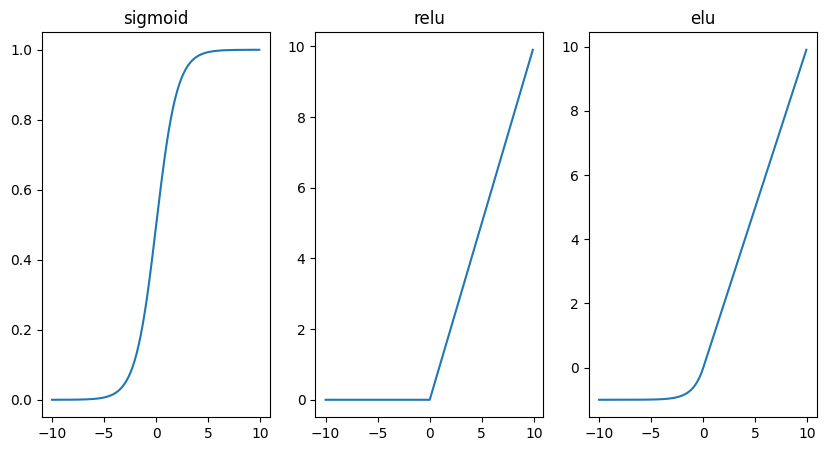

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

In [5]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [7]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# NN with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# TODO 2: Train a Neural Network model
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 82s 782ms/step - loss: 14.5661 - accuracy: 0.3385 - val_loss: 3.9569 - val_accuracy: 0.3297
Epoch 2/10
104/104 [==============================] - 81s 779ms/step - loss: 2.9505 - accuracy: 0.4085 - val_loss: 2.1620 - val_accuracy: 0.4189
Epoch 3/10
104/104 [==============================] - 80s 770ms/step - loss: 1.8462 - accuracy: 0.4794 - val_loss: 2.0761 - val_accuracy: 0.4486
Epoch 4/10
104/104 [==============================] - 81s 774ms/step - loss: 2.6180 - accuracy: 0.4485 - val_loss: 2.5436 - val_accuracy: 0.3459
Epoch 5/10
104/104 [==============================] - 81s 780ms/step - loss: 1.9834 - accuracy: 0.4536 - val_loss: 2.3718 - val_accuracy: 0.3595
Epoch 6/10
104/104 [==============================] - 81s 775ms/step - loss: 1.3296 - accuracy: 0.5433 - val_loss: 1.8228 - val_accuracy: 0.4000
Epoch 7/10
104/104 [==============================] - 80s 772ms/step - loss: 1.1127 - accuracy: 0.6033 - val_loss: 2.4180 - val_a

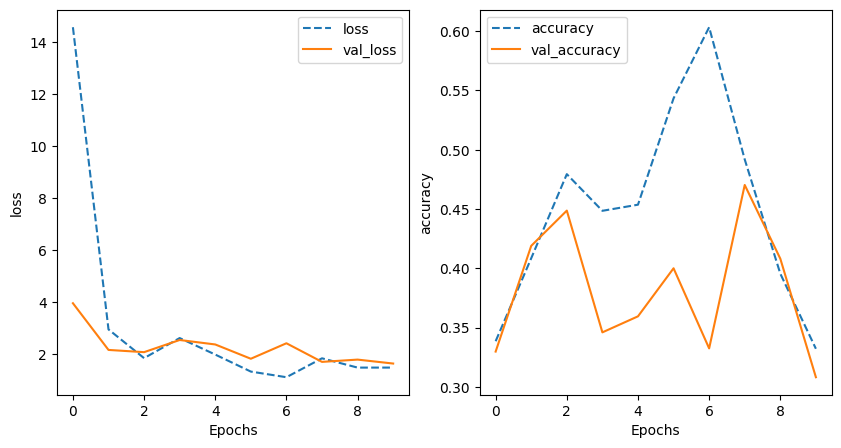

In [8]:
training_plot(['loss', 'accuracy'], history)

## Training the neural network

Training the neural network is similar to training the linear model. Compile the model passing in the optimizer, the loss, and the metrics. Then, call model.fit() passing in the datasets.

In [9]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # default in Adam constructor
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with one hidden layers
  model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

First, train your model by using 128 hidden layers.

Epoch 1/10
104/104 [==============================] - 82s 778ms/step - loss: 2.2393 - accuracy: 0.2794 - val_loss: 1.5021 - val_accuracy: 0.3162
Epoch 2/10
104/104 [==============================] - 81s 773ms/step - loss: 1.5495 - accuracy: 0.2870 - val_loss: 1.4755 - val_accuracy: 0.3162
Epoch 3/10
104/104 [==============================] - 81s 778ms/step - loss: 1.5303 - accuracy: 0.2991 - val_loss: 1.4642 - val_accuracy: 0.3297
Epoch 4/10
104/104 [==============================] - 80s 769ms/step - loss: 1.5169 - accuracy: 0.3055 - val_loss: 1.4552 - val_accuracy: 0.3324
Epoch 5/10
104/104 [==============================] - 80s 771ms/step - loss: 1.5187 - accuracy: 0.2924 - val_loss: 1.4329 - val_accuracy: 0.3595
Epoch 6/10
104/104 [==============================] - 81s 775ms/step - loss: 1.4855 - accuracy: 0.3394 - val_loss: 1.4150 - val_accuracy: 0.3865
Epoch 7/10
104/104 [==============================] - 80s 765ms/step - loss: 1.4661 - accuracy: 0.3748 - val_loss: 1.4060 - val_ac

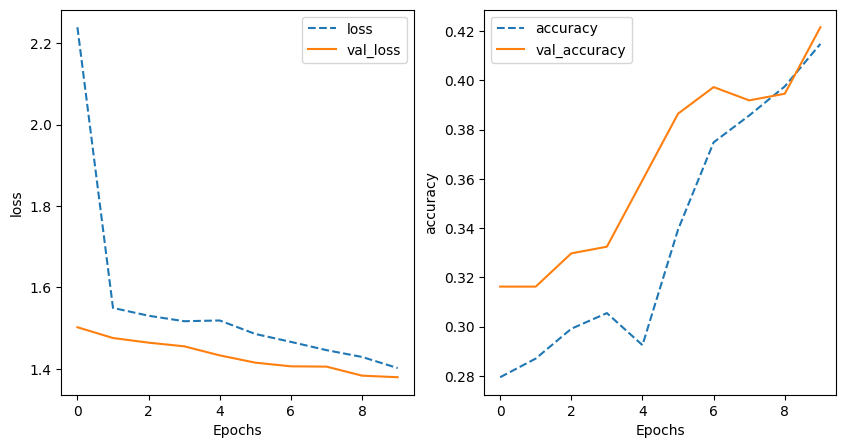

In [10]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

You would normally expect that adding layers to a model will improve the ability of the model to fit the training data, and thus lower the loss. Notice that it is not always the case though.

Epoch 1/10
104/104 [==============================] - 93s 888ms/step - loss: 2.7313 - accuracy: 0.3591 - val_loss: 2.1860 - val_accuracy: 0.3027
Epoch 2/10
104/104 [==============================] - 91s 867ms/step - loss: 1.8991 - accuracy: 0.4103 - val_loss: 2.0801 - val_accuracy: 0.3973
Epoch 3/10
104/104 [==============================] - 91s 875ms/step - loss: 1.6201 - accuracy: 0.4700 - val_loss: 2.0403 - val_accuracy: 0.3432
Epoch 4/10
104/104 [==============================] - 90s 866ms/step - loss: 1.5427 - accuracy: 0.4624 - val_loss: 1.5208 - val_accuracy: 0.4459
Epoch 5/10
104/104 [==============================] - 88s 847ms/step - loss: 1.4358 - accuracy: 0.5052 - val_loss: 1.2946 - val_accuracy: 0.4811
Epoch 6/10
104/104 [==============================] - 90s 864ms/step - loss: 1.2245 - accuracy: 0.5576 - val_loss: 1.3093 - val_accuracy: 0.4784
Epoch 7/10
104/104 [==============================] - 90s 861ms/step - loss: 1.1485 - accuracy: 0.5888 - val_loss: 1.3513 - val_ac

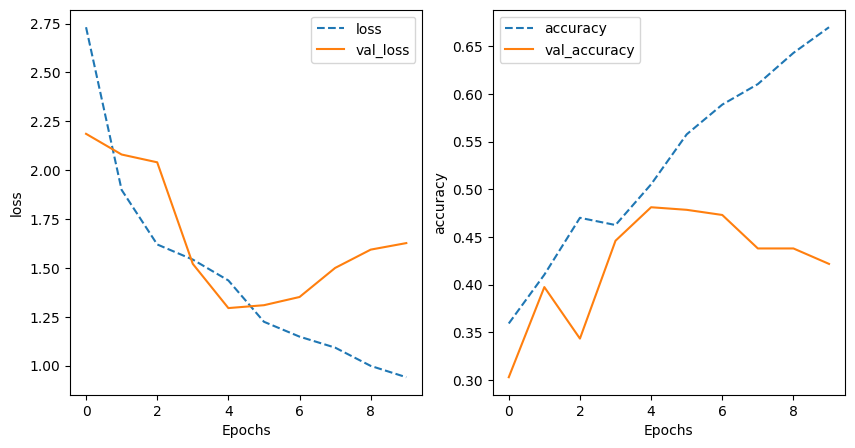

In [11]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

## Train and evaluate a Deep Neural Network model

Now train a DNN. You need to parameterize the number of layers, and the number of nodes in each layer.

In [12]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
  ]
  layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_pixels (Flatten)      (None, 150528)            0         
                                                                 
 hidden_dense_0 (Dense)      (None, 64)                9633856   
                                                                 
 hidden_dense_1 (Dense)      (None, 16)                1040      
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 77s 734ms/step - loss: 1.6554 - accuracy: 0.3597 - val_loss: 1.7027 - val_accuracy: 0.3757
Epoch 2/10
104/10

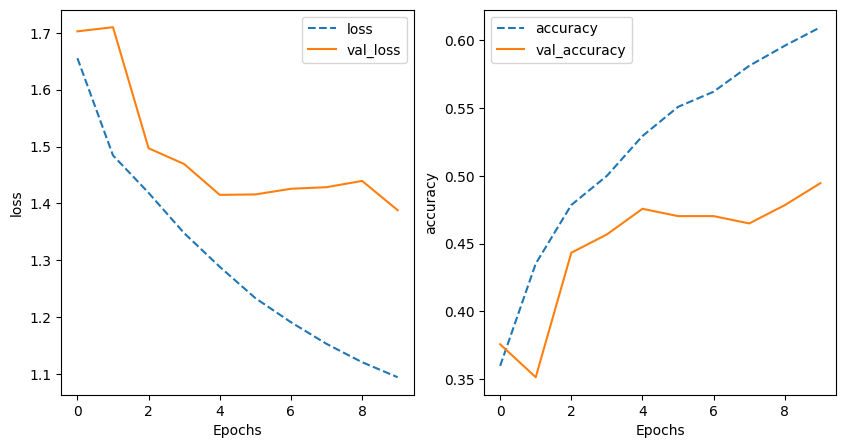

In [13]:
# TODO 3: Train and evaluate a DNN model
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

Congrats! You've completed the lab!